# Introduction:
Database Project for a Market,

Abolfazl Arab Ansari

Satisfy functionalities of a Market between Company, Supplier, Consumer, and Product


## Phase Zero: 
### Entity Relationship Digram
Now about the different Point of Views of application
We want to design a database for a platform for a market. 
You can see the ER Diagram here   

( NOTE: it could be different ways to approach this problem and there is not an unique solution. )



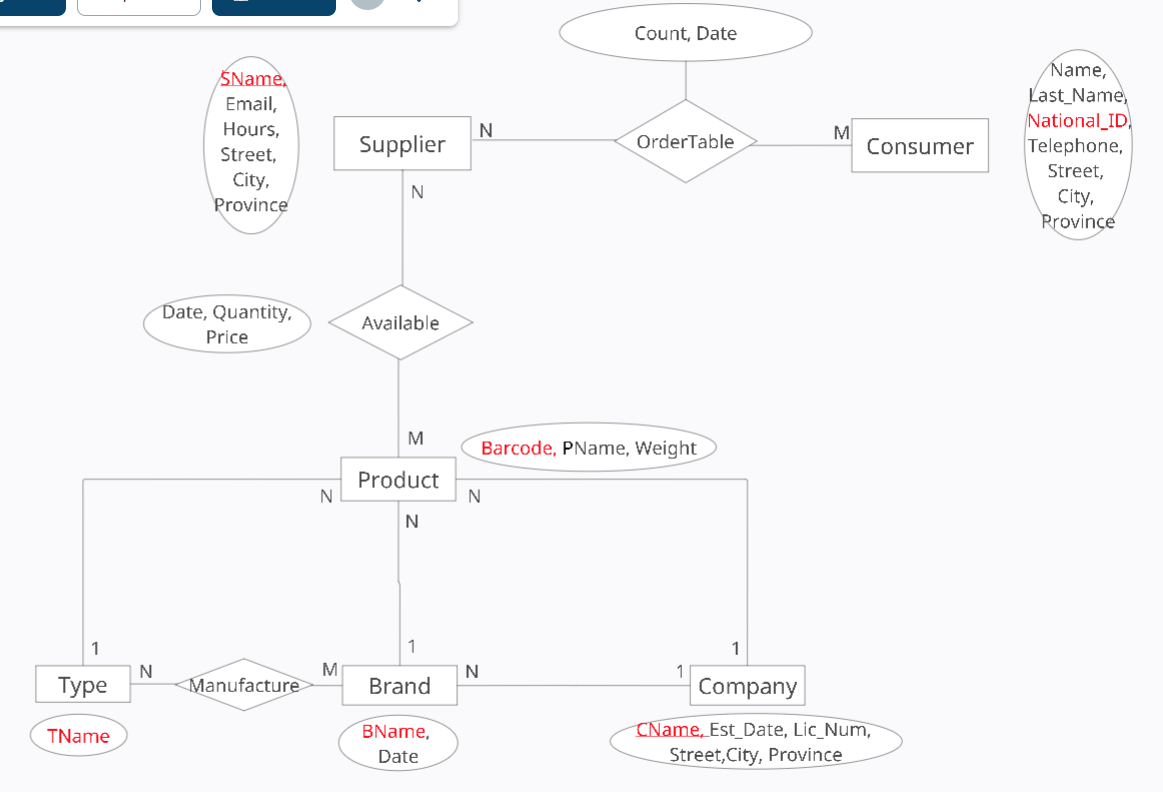

In [1]:
from IPython.display import Image
Image("ERD0c.png")

## Phase One:
### Normalize your Schema ( We do til BCNF Level )

## Implement
### Import needed package and connect with sql server

In [37]:
# Import needed packages
import pyodbc

print ( 'All Drivers are: ')
for drivers in pyodbc.drivers(): 
    print ( drivers )


# to connect we need two things:
#   server name: read from sql server
#   database name: we use URL Dashboard database that we defined

server = 'DESKTOP-696L0M6'
database = 'DB2'

# define connection string
conn_str = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                         SERVER=' + server + '; \
                         DATABASE=' + database +'; \
                         Trusted_Connection=yes;')


# Create the connection cursor
cursor = conn_str.cursor()

print ( f'Cursor is {cursor}' )

All Drivers are: 
SQL Server
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server
Cursor is <pyodbc.Cursor object at 0x00000246E53391B0>


## Phase Two:
### Database Schema

In [38]:
# Write Schema of our Database


create_schema = '''

-- Supplier table
CREATE TABLE Supplier (
  SName varchar(50) PRIMARY KEY,
  Email varchar(50),
  Hours varchar(50),
  Street varchar(50),
  City varchar(50),
  Province varchar(50)
);

-- Consumer table
CREATE TABLE Consumer (
  National_ID int PRIMARY KEY,
  Name varchar(50),
  Last_Name varchar(50),
  Telephone varchar(20),
  Street varchar(50),
  City varchar(50),
  Province varchar(50)
);

-- Company table
CREATE TABLE Company (
  CName varchar(50) PRIMARY KEY,
  EstDate date,
  Lic_Num varchar(50),
  Street varchar(50),
  City varchar(50),
  Province varchar(50)
);

-- Type table
CREATE TABLE Type (
  TName varchar(50) PRIMARY KEY
);

-- Brand table
CREATE TABLE Brand (
  BName varchar(50) PRIMARY KEY,
  CName varchar(50),
  BrandDate date,
  FOREIGN KEY (CName) REFERENCES Company(CName)
);


-- Manufacture table
CREATE TABLE Manufacture (
  BName varchar(50),
  TName varchar(50),
  PRIMARY KEY (BName, TName),
  FOREIGN KEY (BName) REFERENCES Brand(BName),
  FOREIGN KEY (TName) REFERENCES Type(TName)
);

-- Product table
CREATE TABLE Product (
  Barcode int PRIMARY KEY,
  PName varchar(50),
  TName varchar(50),
  BName varchar(50),
  CName varchar(50),
  Weight decimal(10,2),
  FOREIGN KEY (CName) REFERENCES Company(CName),
  FOREIGN KEY (BName, TName) REFERENCES Manufacture(BName, TName)
);

-- Available table
CREATE TABLE Available (
  SName varchar(50),
  Barcode int,
  AvailableDate date,
  Quantity int,
  Price decimal(10,2),
  PRIMARY KEY (SName, Barcode, AvailableDate),
  FOREIGN KEY (SName) REFERENCES Supplier(SName),
  FOREIGN KEY (Barcode) REFERENCES Product(Barcode)
);

-- Order table
CREATE TABLE OrderTable (
  National_ID int,
  SName varchar(50),
  Barcode int,
  Count int,
  OrderDate date,
  PRIMARY KEY (National_ID, SName, Barcode),
  FOREIGN KEY (National_ID) REFERENCES Consumer(National_ID),
  FOREIGN KEY (SName, Barcode, OrderDate) REFERENCES Available(SName, Barcode, AvailableDate)
);


'''



# Execute the sql statement to create tables
cursor.execute(create_schema)


# Commit the changes and close the cursor
cursor.commit()


In [39]:
# Define the function select_all
def select_all(table_name):
    command = f'SELECT * FROM {table_name}'
    print(f'The result of {command} is:')
    cursor.execute(command)
    records = cursor.fetchall()
    for record in records: 
        print(record)

# Example usage
# select_all('Supplier')


In [40]:
# Define Vital Triggers

# Reduce Availability on Supplier 
reduce_availability = """
    CREATE TRIGGER ReduceAvailability
    ON OrderTable
    INSTEAD OF INSERT
    AS
    BEGIN
        -- Decrease availability count only for valid orders
        UPDATE Available
        SET Quantity = Quantity - I.Count
        FROM Available A
        INNER JOIN INSERTED I ON A.SName = I.SName AND A.Barcode = I.Barcode AND A.AvailableDate = I.OrderDate
        WHERE A.Quantity >= I.Count;

        -- Insert the valid orders into OrderTable
        INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate)
        SELECT National_ID, SName, Barcode, Count, OrderDate
        FROM INSERTED I
        WHERE NOT EXISTS (
            SELECT *
            FROM Available A
            WHERE A.SName = I.SName AND A.Barcode = I.Barcode AND A.AvailableDate = I.OrderDate AND A.Quantity < I.Count
        );
    END;
"""

# Execute the sql statement for trigger
cursor.execute(reduce_availability)


# Commit the changes and close the cursor
cursor.commit()

In [41]:
# Define Vital Triggers

# Increase Availability on Supplier 
increase_availability = """
    CREATE TRIGGER IncreaseAvailability
    ON Available
    INSTEAD OF INSERT
    AS
    BEGIN
        -- Insert new rows for products that don't exist in the table
        INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price)
        SELECT I.SName, I.Barcode, I.AvailableDate, I.Quantity, I.Price
        FROM INSERTED I
        LEFT JOIN Available A ON A.SName = I.SName AND A.Barcode = I.Barcode AND A.AvailableDate = I.AvailableDate
        WHERE A.SName IS NULL;

        -- Update the existing availability count for products that already exist in the table
        UPDATE A
        SET A.Quantity = A.Quantity + I.Quantity
        FROM Available A
        INNER JOIN INSERTED I ON A.SName = I.SName AND A.Barcode = I.Barcode AND A.AvailableDate = I.AvailableDate
        WHERE A.SName IS NOT NULL;
    END;
"""

# Execute the SQL statement for trigger
cursor.execute(increase_availability)

# Commit the changes and close the cursor
cursor.commit()

## Phase Three:
### Insertion

In [42]:
# Insert data into the Supplier table ( 4 )
cursor.execute("""
    --- Supplier
    INSERT INTO Supplier (SName, Email, Hours, Street, City, Province) VALUES ('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Supplier (SName, Email, Hours, Street, City, Province) VALUES ('Supplier2', 'supplier2@example.com', '7 AM - 5 PM', 'Street 1', 'City 2', 'Province 1');
    INSERT INTO Supplier (SName, Email, Hours, Street, City, Province) VALUES ('Supplier3', 'supplier3@example.com', '8 AM - 5 PM', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Supplier (SName, Email, Hours, Street, City, Province) VALUES ('Supplier4', 'supplier4@example.com', '9 AM - 5 PM', 'Street 1', 'City 2', 'Province 1');

""")

cursor.execute("""
    --- Consumer
    INSERT INTO Consumer (National_ID, Name, Last_Name, Telephone, Street, City, Province) VALUES (1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Consumer (National_ID, Name, Last_Name, Telephone, Street, City, Province) VALUES (1002, 'Consumer2', 'Lastname2', '1002', 'Street 1', 'City 2', 'Province 1');
    INSERT INTO Consumer (National_ID, Name, Last_Name, Telephone, Street, City, Province) VALUES (1003, 'Consumer3', 'Lastname3', '1003', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Consumer (National_ID, Name, Last_Name, Telephone, Street, City, Province) VALUES (1004, 'Consumer4', 'Lastname4', '1004', 'Street 1', 'City 2', 'Province 1');
    INSERT INTO Consumer (National_ID, Name, Last_Name, Telephone, Street, City, Province) VALUES (1005, 'Consumer5', 'Lastname5', '1005', 'Street 1', 'City 1', 'Province 1');

""")

cursor.execute("""
 
   --- Company
    INSERT INTO Company (CName, EstDate, Lic_Num, Street, City, Province) VALUES ('Company1', '2022-01-01', 'License1', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Company (CName, EstDate, Lic_Num, Street, City, Province) VALUES ('Company2', '2022-01-01', 'License2', 'Street 2', 'City 1', 'Province 1');
    INSERT INTO Company (CName, EstDate, Lic_Num, Street, City, Province) VALUES ('Company3', '2022-01-01', 'License3', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Company (CName, EstDate, Lic_Num, Street, City, Province) VALUES ('Company4', '2022-01-01', 'License4', 'Street 2', 'City 1', 'Province 1');
    INSERT INTO Company (CName, EstDate, Lic_Num, Street, City, Province) VALUES ('Company5', '2022-01-01', 'License5', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Company (CName, EstDate, Lic_Num, Street, City, Province) VALUES ('Company6', '2022-01-01', 'License6', 'Street 2', 'City 1', 'Province 1');

""")

cursor.execute("""
    --- Type
    INSERT INTO Type (TName) VALUES ('Type1');
    INSERT INTO Type (TName) VALUES ('Type2');
    INSERT INTO Type (TName) VALUES ('Type3');
    INSERT INTO Type (TName) VALUES ('Type4');
    INSERT INTO Type (TName) VALUES ('Type5');
    INSERT INTO Type (TName) VALUES ('Type6');
    INSERT INTO Type (TName) VALUES ('Type7');
    INSERT INTO Type (TName) VALUES ('Type8');
    INSERT INTO Type (TName) VALUES ('Type9');
    INSERT INTO Type (TName) VALUES ('Type10');

""")

cursor.execute("""
    --- Brand
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand1', 'Company1', '2022-01-01');
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand2', 'Company2', '2022-01-01');
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand3', 'Company3', '2022-01-01');
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand4', 'Company4', '2022-01-01');
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand5', 'Company5', '2022-01-01');
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand6', 'Company6', '2022-01-01');
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand7', 'Company1', '2022-01-01');
    INSERT INTO Brand (BName, CName, BrandDate) VALUES ('Brand8', 'Company2', '2022-01-01');

""")

cursor.execute("""
    --- Manufacture
    INSERT INTO Manufacture (TName, BName) VALUES ('Type1', 'Brand1');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type2', 'Brand2');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type3', 'Brand3');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type4', 'Brand4');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type5', 'Brand5');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type6', 'Brand6');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type7', 'Brand7');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type8', 'Brand8');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type9', 'Brand1');
    INSERT INTO Manufacture (TName, BName) VALUES ('Type10', 'Brand2');

""")

cursor.execute("""
    --- Product
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1001, 'Product1', 'Type1', 'Brand1', 'Company1', 1.5);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1002, 'Product2', 'Type2', 'Brand2', 'Company2', 1);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1003, 'Product3', 'Type3', 'Brand3', 'Company3', 1.5);    
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1004, 'Product4', 'Type4', 'Brand4', 'Company4', 1);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1005, 'Product5', 'Type5', 'Brand5', 'Company5', 1.5);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1006, 'Product6', 'Type6', 'Brand6', 'Company6', 1);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1007, 'Product7', 'Type7', 'Brand7', 'Company1', 1.5);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1008, 'Product8', 'Type8', 'Brand8', 'Company2', 1);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1009, 'Product9', 'Type9', 'Brand1', 'Company1', 1.5);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1010, 'Product10', 'Type10', 'Brand2', 'Company2', 1);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1011, 'Product11', 'Type1', 'Brand1', 'Company3', 1.5);
    INSERT INTO Product (Barcode, PName, TName, BName, CName, Weight) VALUES (1012, 'Product12', 'Type2', 'Brand2', 'Company4', 1);

""")

cursor.execute("""
    --- Available
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1001, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1002, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1003, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1004, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1005, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1006, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1007, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1008, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1009, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1010, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1011, '2022-01-01', 10, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1012, '2022-01-01', 10, 9.99);

    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1001, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1002, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1003, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1004, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1005, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1006, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1007, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1008, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1009, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1010, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1011, '2022-01-01', 10, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1012, '2022-01-01', 10, 9.98);

    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1001, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1002, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1003, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1004, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1005, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1006, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1007, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1008, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1009, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1010, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1011, '2022-01-01', 10, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1012, '2022-01-01', 10, 9.97);

    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1001, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1002, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1003, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1004, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1005, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1006, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1007, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1008, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1009, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1010, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1011, '2022-01-01', 10, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1012, '2022-01-01', 10, 9.96);

""")

cursor.execute(""" 
    --- Order
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1001, 'Supplier1', 1001, 2, '2022-01-01');
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1001, 'Supplier2', 1002, 2, '2022-01-01');
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1001, 'Supplier3', 1003, 2, '2022-01-01');    

    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1002, 'Supplier1', 1002, 2, '2022-01-01');
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1002, 'Supplier2', 1003, 2, '2022-01-01');
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1002, 'Supplier3', 1001, 2, '2022-01-01');

    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1003, 'Supplier1', 1003, 2, '2022-01-01');
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1003, 'Supplier2', 1001, 2, '2022-01-01');
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (1003, 'Supplier3', 1002, 2, '2022-01-01');    
    """
    )


# Commit the changes
cursor.commit()


In [43]:
select_all('Supplier')

The result of SELECT * FROM Supplier is:
('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1')
('Supplier2', 'supplier2@example.com', '7 AM - 5 PM', 'Street 1', 'City 2', 'Province 1')
('Supplier3', 'supplier3@example.com', '8 AM - 5 PM', 'Street 1', 'City 1', 'Province 1')
('Supplier4', 'supplier4@example.com', '9 AM - 5 PM', 'Street 1', 'City 2', 'Province 1')


## Phase Four:
### Insert Specific Info

In [44]:
cursor.execute("""
    INSERT INTO Consumer (National_ID, Name, Last_Name, Telephone, Street, City, Province)
    VALUES (12345, 'Harry', 'Kane', '+44796268462', '212 Baker Street', 'London', 'London');
""")

In [46]:
select_all('OrderTable')

The result of SELECT * FROM OrderTable is:
(1001, 'Supplier1', 1001, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1002, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1003, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier1', 1002, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier2', 1003, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier3', 1001, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier1', 1003, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier2', 1001, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier3', 1002, 2, datetime.date(2022, 1, 1))


In [47]:
harry_orders = """
    INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES
    (12345, 'Supplier1', 1001, 3, '2022-01-01'),
    (12345, 'Supplier2', 1002, 3, '2022-01-01'),
    (12345, 'Supplier3', 1003, 3, '2022-01-01');
"""

cursor.execute(harry_orders)

In [48]:
select_all('OrderTable')

The result of SELECT * FROM OrderTable is:
(1001, 'Supplier1', 1001, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1002, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1003, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier1', 1002, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier2', 1003, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier3', 1001, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier1', 1003, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier2', 1001, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier3', 1002, 2, datetime.date(2022, 1, 1))
(12345, 'Supplier1', 1001, 3, datetime.date(2022, 1, 1))
(12345, 'Supplier2', 1002, 3, datetime.date(2022, 1, 1))
(12345, 'Supplier3', 1003, 3, datetime.date(2022, 1, 1))


In [49]:
update_harry = """
    UPDATE Consumer
    SET Telephone = '+447342780080'
    WHERE Name = 'Harry' AND Last_Name = 'Kane';
"""

cursor.execute(update_harry)
cursor.commit()

In [50]:
select_all("Consumer")

The result of SELECT * FROM Consumer is:
(1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1')
(1002, 'Consumer2', 'Lastname2', '1002', 'Street 1', 'City 2', 'Province 1')
(1003, 'Consumer3', 'Lastname3', '1003', 'Street 1', 'City 1', 'Province 1')
(1004, 'Consumer4', 'Lastname4', '1004', 'Street 1', 'City 2', 'Province 1')
(1005, 'Consumer5', 'Lastname5', '1005', 'Street 1', 'City 1', 'Province 1')
(12345, 'Harry', 'Kane', '+447342780080', '212 Baker Street', 'London', 'London')


In [51]:
# Consumer 4 and 5 did't sumbit any order
select_all("Consumer")

remove_consumers = """
DELETE FROM Consumer
WHERE National_ID NOT IN (
    SELECT DISTINCT National_ID
    FROM OrderTable
);
"""
cursor.execute(remove_consumers)

select_all("Consumer")
cursor.commit()

The result of SELECT * FROM Consumer is:
(1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1')
(1002, 'Consumer2', 'Lastname2', '1002', 'Street 1', 'City 2', 'Province 1')
(1003, 'Consumer3', 'Lastname3', '1003', 'Street 1', 'City 1', 'Province 1')
(1004, 'Consumer4', 'Lastname4', '1004', 'Street 1', 'City 2', 'Province 1')
(1005, 'Consumer5', 'Lastname5', '1005', 'Street 1', 'City 1', 'Province 1')
(12345, 'Harry', 'Kane', '+447342780080', '212 Baker Street', 'London', 'London')
The result of SELECT * FROM Consumer is:
(1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1')
(1002, 'Consumer2', 'Lastname2', '1002', 'Street 1', 'City 2', 'Province 1')
(1003, 'Consumer3', 'Lastname3', '1003', 'Street 1', 'City 1', 'Province 1')
(12345, 'Harry', 'Kane', '+447342780080', '212 Baker Street', 'London', 'London')


### Some more insertion

In [52]:
# Some more data

cursor.execute("""
    --- Supplier
    INSERT INTO Supplier (SName, Email, Hours, Street, City, Province) VALUES ('Supplier5', 'supplier5@example.com', '10 AM - 5 PM', 'Street 1', 'City 1', 'Province 1');
    INSERT INTO Supplier (SName, Email, Hours, Street, City, Province) VALUES ('Supplier6', 'supplier6@example.com', '11 AM - 5 PM', 'Street 1', 'City 2', 'Province 1');

""")

cursor.execute("""
    --- Add Available to new Suppliers
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1001, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1002, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1003, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1004, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1005, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1006, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1007, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1008, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1009, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1010, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1011, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier5', 1012, '2022-01-01', 80, 9.99);

    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1001, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1002, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1003, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1004, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1005, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1006, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1007, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1008, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1009, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1010, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1011, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier6', 1012, '2022-01-01', 80, 9.99);
    

    --- Some Available
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1001, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1002, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1003, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1004, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1005, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1006, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1007, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1008, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1009, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1010, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1011, '2022-01-01', 80, 9.99);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier1', 1012, '2022-01-01', 80, 9.99);

    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1001, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1002, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1003, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1004, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1005, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1006, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1007, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1008, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1009, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1010, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1011, '2022-01-01', 80, 9.98);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier2', 1012, '2022-01-01', 80, 9.98);

    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1001, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1002, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1003, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1004, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1005, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1006, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1007, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1008, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1009, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1010, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1011, '2022-01-01', 80, 9.97);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier3', 1012, '2022-01-01', 80, 9.97);
    
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1001, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1002, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1003, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1004, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1005, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1006, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1007, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1008, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1009, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1010, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1011, '2022-01-01', 80, 9.96);
    INSERT INTO Available (SName, Barcode, AvailableDate, Quantity, Price) VALUES ('Supplier4', 1012, '2022-01-01', 80, 9.96);

""")


In [53]:
select_all('Available')

The result of SELECT * FROM Available is:
('Supplier1', 1001, datetime.date(2022, 1, 1), 95, Decimal('9.99'))
('Supplier1', 1002, datetime.date(2022, 1, 1), 98, Decimal('9.99'))
('Supplier1', 1003, datetime.date(2022, 1, 1), 98, Decimal('9.99'))
('Supplier1', 1004, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1005, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1006, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1007, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1008, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1009, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1010, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1011, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier1', 1012, datetime.date(2022, 1, 1), 100, Decimal('9.99'))
('Supplier2', 1001, datetime.date(2022, 1, 1), 98, Decimal('9.98'))
('Supplier2', 1002, datetime.date(2022, 1, 1), 95, Decimal('9.98'

In [54]:
select_all('OrderTable')

The result of SELECT * FROM OrderTable is:
(1001, 'Supplier1', 1001, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1002, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1003, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier1', 1002, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier2', 1003, 2, datetime.date(2022, 1, 1))
(1002, 'Supplier3', 1001, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier1', 1003, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier2', 1001, 2, datetime.date(2022, 1, 1))
(1003, 'Supplier3', 1002, 2, datetime.date(2022, 1, 1))
(12345, 'Supplier1', 1001, 3, datetime.date(2022, 1, 1))
(12345, 'Supplier2', 1002, 3, datetime.date(2022, 1, 1))
(12345, 'Supplier3', 1003, 3, datetime.date(2022, 1, 1))


In [55]:
import random


for _ in range(0,200):

    cursor.execute("SELECT * FROM Available WHERE Quantity > 0")
    Product = cursor.fetchall()
    cursor.execute("SELECT * FROM Consumer")
    Consumer = cursor.fetchall()
    cursor.commit()

    Consumer_Shuffle = random.choice(Consumer)
    Product_Shuffle = random.choice(Product)

    SName = Product_Shuffle[0]
    Barcode = Product_Shuffle[1]
    OrderDate = Product_Shuffle[2]
    National_ID = Consumer_Shuffle[0]

    cursor.execute("INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (?,?,?,?,?)", (National_ID, SName, Barcode, 1, OrderDate))

    cursor.commit()

In [56]:
select_all('OrderTable')

The result of SELECT * FROM OrderTable is:
(1001, 'Supplier1', 1001, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1002, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1003, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1004, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1005, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1008, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1009, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1002, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1004, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1008, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1009, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1010, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1002, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1003, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1004, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1006, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1007, 1, datetime.date(2022, 1, 1))
(1001

In [57]:
select_all('Available')

The result of SELECT * FROM Available is:
('Supplier1', 1001, datetime.date(2022, 1, 1), 94, Decimal('9.99'))
('Supplier1', 1002, datetime.date(2022, 1, 1), 96, Decimal('9.99'))
('Supplier1', 1003, datetime.date(2022, 1, 1), 96, Decimal('9.99'))
('Supplier1', 1004, datetime.date(2022, 1, 1), 98, Decimal('9.99'))
('Supplier1', 1005, datetime.date(2022, 1, 1), 98, Decimal('9.99'))
('Supplier1', 1006, datetime.date(2022, 1, 1), 99, Decimal('9.99'))
('Supplier1', 1007, datetime.date(2022, 1, 1), 98, Decimal('9.99'))
('Supplier1', 1008, datetime.date(2022, 1, 1), 96, Decimal('9.99'))
('Supplier1', 1009, datetime.date(2022, 1, 1), 98, Decimal('9.99'))
('Supplier1', 1010, datetime.date(2022, 1, 1), 97, Decimal('9.99'))
('Supplier1', 1011, datetime.date(2022, 1, 1), 97, Decimal('9.99'))
('Supplier1', 1012, datetime.date(2022, 1, 1), 99, Decimal('9.99'))
('Supplier2', 1001, datetime.date(2022, 1, 1), 98, Decimal('9.98'))
('Supplier2', 1002, datetime.date(2022, 1, 1), 93, Decimal('9.98'))
('Supp

## Phase Five:
### Some Queries:

In [58]:
# Top 10 Products for each Supplier

cursor.execute("""
WITH SupplierPopularProducts AS (
  SELECT s.SName, p.PName, COUNT(*) as total_sales,
    ROW_NUMBER() OVER (PARTITION BY s.SName ORDER BY COUNT(*) DESC) AS rn
  FROM Supplier s
  JOIN Available a ON s.SName = a.SName
  JOIN Product p ON a.Barcode = p.Barcode
  JOIN OrderTable o ON a.SName = o.SName AND a.Barcode = o.Barcode
  GROUP BY s.SName, p.PName
)
SELECT SName, PName, total_sales
FROM SupplierPopularProducts
WHERE rn <= 10;
""")

top_10s = cursor.fetchall()
top_10s

[('Supplier1', 'Product8', 4),
 ('Supplier1', 'Product1', 3),
 ('Supplier1', 'Product10', 3),
 ('Supplier1', 'Product11', 3),
 ('Supplier1', 'Product2', 3),
 ('Supplier1', 'Product3', 3),
 ('Supplier1', 'Product4', 2),
 ('Supplier1', 'Product5', 2),
 ('Supplier1', 'Product9', 2),
 ('Supplier1', 'Product7', 2),
 ('Supplier2', 'Product2', 4),
 ('Supplier2', 'Product4', 3),
 ('Supplier2', 'Product12', 3),
 ('Supplier2', 'Product10', 3),
 ('Supplier2', 'Product7', 3),
 ('Supplier2', 'Product6', 2),
 ('Supplier2', 'Product8', 2),
 ('Supplier2', 'Product9', 1),
 ('Supplier2', 'Product1', 1),
 ('Supplier2', 'Product11', 1),
 ('Supplier3', 'Product3', 4),
 ('Supplier3', 'Product2', 4),
 ('Supplier3', 'Product4', 3),
 ('Supplier3', 'Product12', 3),
 ('Supplier3', 'Product1', 3),
 ('Supplier3', 'Product10', 3),
 ('Supplier3', 'Product11', 2),
 ('Supplier3', 'Product9', 2),
 ('Supplier3', 'Product6', 2),
 ('Supplier3', 'Product7', 2),
 ('Supplier4', 'Product5', 3),
 ('Supplier4', 'Product10', 3),

In [59]:
# Top 10 products for each Cities

cursor.execute("""
WITH CityPopularProducts AS (
  SELECT c.City, p.PName, COUNT(*) as total_sales,
    ROW_NUMBER() OVER (PARTITION BY c.City ORDER BY COUNT(*) DESC) AS rn
  FROM Consumer c
  JOIN OrderTable o ON c.National_ID = o.National_ID
  JOIN Product p ON o.Barcode = p.Barcode
  GROUP BY c.City, p.PName
)
SELECT City, PName, total_sales
FROM CityPopularProducts
WHERE rn <= 10;
""")

top_10s_city = cursor.fetchall()
top_10s_city

[('City 1', 'Product2', 10),
 ('City 1', 'Product10', 9),
 ('City 1', 'Product12', 9),
 ('City 1', 'Product8', 9),
 ('City 1', 'Product1', 7),
 ('City 1', 'Product3', 7),
 ('City 1', 'Product4', 7),
 ('City 1', 'Product9', 6),
 ('City 1', 'Product7', 5),
 ('City 1', 'Product5', 4),
 ('City 2', 'Product2', 6),
 ('City 2', 'Product3', 4),
 ('City 2', 'Product12', 4),
 ('City 2', 'Product10', 4),
 ('City 2', 'Product7', 4),
 ('City 2', 'Product6', 2),
 ('City 2', 'Product9', 2),
 ('City 2', 'Product11', 2),
 ('City 2', 'Product5', 2),
 ('City 2', 'Product4', 1),
 ('London', 'Product10', 5),
 ('London', 'Product11', 5),
 ('London', 'Product5', 5),
 ('London', 'Product7', 4),
 ('London', 'Product6', 3),
 ('London', 'Product8', 3),
 ('London', 'Product4', 3),
 ('London', 'Product3', 3),
 ('London', 'Product1', 3),
 ('London', 'Product2', 2)]

In [60]:
# Top 5 Suppliers with most sold item in 2022

cursor.execute("""
SELECT TOP 5 SName, SUM(Count) AS total_sales
FROM OrderTable
WHERE YEAR(OrderDate) = 2022
GROUP BY SName
ORDER BY total_sales DESC;
""")

top_5s_yearsupplier = cursor.fetchall()
top_5s_yearsupplier

[('Supplier1', 34),
 ('Supplier3', 34),
 ('Supplier2', 29),
 ('Supplier6', 27),
 ('Supplier5', 20)]

In [61]:
# Suppliers who sold Product1 more than Product2

cursor.execute('''
SELECT product1_sales.SName
FROM (
    SELECT OT.SName, SUM(OT.Count) AS total_product1_sales
    FROM OrderTable OT
    INNER JOIN Product P ON OT.Barcode = P.Barcode
    WHERE P.PName = 'Product1'
    GROUP BY OT.SName
) AS product1_sales
INNER JOIN (
    SELECT OT.SName, SUM(OT.Count) AS total_product2_sales
    FROM OrderTable OT
    INNER JOIN Product P ON OT.Barcode = P.Barcode
    WHERE P.PName = 'Product2'
    GROUP BY OT.SName
) AS product2_sales ON product1_sales.SName = product2_sales.SName
WHERE product1_sales.total_product1_sales > product2_sales.total_product2_sales;
''')

suppliers_1more2 = cursor.fetchall()
suppliers_1more2


[('Supplier1',)]

In [62]:
# Top 3 Products that sold along with Milk ( Milk = Product3 )

cursor.execute('''
SELECT TOP 3 P2.PName, COUNT(*) AS total_sales
FROM OrderTable OT1
INNER JOIN Product P1 ON OT1.Barcode = P1.Barcode
INNER JOIN OrderTable OT2 ON OT1.National_ID = OT2.National_ID
INNER JOIN Product P2 ON OT2.Barcode = P2.Barcode
WHERE P1.PName = 'Product3' AND P2.PName <> 'Product3'
GROUP BY P2.PName
ORDER BY total_sales DESC;
''')

top_3_products = cursor.fetchall()
top_3_products


[('Product2', 65), ('Product10', 61), ('Product7', 47)]

## Phase Six:
### Create views

In [63]:
# Create the view of suppliers with products that they sold with all information

cursor.execute("""
    CREATE VIEW distributor_distributes AS
    SELECT S.*, P.*
    FROM Supplier S
    JOIN Available A ON S.SName = A.SName
    JOIN Product P ON A.Barcode = P.Barcode;
""")

# Retrieve data from the view
cursor.execute("""
    SELECT * FROM distributor_distributes;
""")

# Fetch the results
distributor_distributes = cursor.fetchall()

distributor_distributes

[('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1', 1001, 'Product1', 'Type1', 'Brand1', 'Company1', Decimal('1.50')),
 ('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1', 1002, 'Product2', 'Type2', 'Brand2', 'Company2', Decimal('1.00')),
 ('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1', 1003, 'Product3', 'Type3', 'Brand3', 'Company3', Decimal('1.50')),
 ('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1', 1004, 'Product4', 'Type4', 'Brand4', 'Company4', Decimal('1.00')),
 ('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1', 1005, 'Product5', 'Type5', 'Brand5', 'Company5', Decimal('1.50')),
 ('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1', 1006, 'Product6', 'Type6', 'Brand6', 'Company6', Decimal('1.00')),
 ('Supplier1', 'supplier1@example.com', '6 AM - 5 PM

In [64]:
# Create the view customer_orders with information of consumer and their orders
cursor.execute("""
    CREATE VIEW customer_orders AS
    SELECT C.*, P.*
    FROM Consumer C
    JOIN OrderTable O ON C.National_ID = O.National_ID
    JOIN Product P ON O.Barcode = P.Barcode;
""")

# Retrieve data from the view
cursor.execute("""
    SELECT * FROM customer_orders;
""")

# Fetch the results
customer_orders = cursor.fetchall()

customer_orders

[(1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1', 1001, 'Product1', 'Type1', 'Brand1', 'Company1', Decimal('1.50')),
 (1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1', 1002, 'Product2', 'Type2', 'Brand2', 'Company2', Decimal('1.00')),
 (1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1', 1003, 'Product3', 'Type3', 'Brand3', 'Company3', Decimal('1.50')),
 (1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1', 1004, 'Product4', 'Type4', 'Brand4', 'Company4', Decimal('1.00')),
 (1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1', 1005, 'Product5', 'Type5', 'Brand5', 'Company5', Decimal('1.50')),
 (1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1', 1008, 'Product8', 'Type8', 'Brand8', 'Company2', Decimal('1.00')),
 (1001, 'Consumer1', 'Lastname1', '1001', 'Street 1', 'City 1', 'Province 1', 1009, 'Product9', 'Type9', 'Brand1', 'Company1', Dec

In [65]:
# Create the view of product with related information of type, brand, and company

cursor.execute("""
    CREATE VIEW product_type_brand_company AS
    SELECT P.Barcode, P.PName, P.Weight, P.TName, P.BName, B.BrandDate, P.CName, C.EstDate, C.Lic_Num, C.Street, C.City, C.Province
    FROM Product P
    JOIN Type T ON P.TName = T.TName
    JOIN Brand B ON P.BName = B.BName
    JOIN Company C ON P.CName = C.CName;
""")

# Retrieve data from the view
cursor.execute("""
    SELECT * FROM product_type_brand_company;
""")

# Fetch the results
product_type_brand_company = cursor.fetchall()

product_type_brand_company


[(1001, 'Product1', Decimal('1.50'), 'Type1', 'Brand1', datetime.date(2022, 1, 1), 'Company1', datetime.date(2022, 1, 1), 'License1', 'Street 1', 'City 1', 'Province 1'),
 (1002, 'Product2', Decimal('1.00'), 'Type2', 'Brand2', datetime.date(2022, 1, 1), 'Company2', datetime.date(2022, 1, 1), 'License2', 'Street 2', 'City 1', 'Province 1'),
 (1003, 'Product3', Decimal('1.50'), 'Type3', 'Brand3', datetime.date(2022, 1, 1), 'Company3', datetime.date(2022, 1, 1), 'License3', 'Street 1', 'City 1', 'Province 1'),
 (1004, 'Product4', Decimal('1.00'), 'Type4', 'Brand4', datetime.date(2022, 1, 1), 'Company4', datetime.date(2022, 1, 1), 'License4', 'Street 2', 'City 1', 'Province 1'),
 (1005, 'Product5', Decimal('1.50'), 'Type5', 'Brand5', datetime.date(2022, 1, 1), 'Company5', datetime.date(2022, 1, 1), 'License5', 'Street 1', 'City 1', 'Province 1'),
 (1006, 'Product6', Decimal('1.00'), 'Type6', 'Brand6', datetime.date(2022, 1, 1), 'Company6', datetime.date(2022, 1, 1), 'License6', 'Street 2',

## Phase Seven: 
### is_sold attribute 

In [66]:
select_all('Supplier')

The result of SELECT * FROM Supplier is:
('Supplier1', 'supplier1@example.com', '6 AM - 5 PM', 'Street 1', 'City 1', 'Province 1')
('Supplier2', 'supplier2@example.com', '7 AM - 5 PM', 'Street 1', 'City 2', 'Province 1')
('Supplier3', 'supplier3@example.com', '8 AM - 5 PM', 'Street 1', 'City 1', 'Province 1')
('Supplier4', 'supplier4@example.com', '9 AM - 5 PM', 'Street 1', 'City 2', 'Province 1')
('Supplier5', 'supplier5@example.com', '10 AM - 5 PM', 'Street 1', 'City 1', 'Province 1')
('Supplier6', 'supplier6@example.com', '11 AM - 5 PM', 'Street 1', 'City 2', 'Province 1')


In [67]:
select_all('Product')

The result of SELECT * FROM Product is:
(1001, 'Product1', 'Type1', 'Brand1', 'Company1', Decimal('1.50'))
(1002, 'Product2', 'Type2', 'Brand2', 'Company2', Decimal('1.00'))
(1003, 'Product3', 'Type3', 'Brand3', 'Company3', Decimal('1.50'))
(1004, 'Product4', 'Type4', 'Brand4', 'Company4', Decimal('1.00'))
(1005, 'Product5', 'Type5', 'Brand5', 'Company5', Decimal('1.50'))
(1006, 'Product6', 'Type6', 'Brand6', 'Company6', Decimal('1.00'))
(1007, 'Product7', 'Type7', 'Brand7', 'Company1', Decimal('1.50'))
(1008, 'Product8', 'Type8', 'Brand8', 'Company2', Decimal('1.00'))
(1009, 'Product9', 'Type9', 'Brand1', 'Company1', Decimal('1.50'))
(1010, 'Product10', 'Type10', 'Brand2', 'Company2', Decimal('1.00'))
(1011, 'Product11', 'Type1', 'Brand1', 'Company3', Decimal('1.50'))
(1012, 'Product12', 'Type2', 'Brand2', 'Company4', Decimal('1.00'))


In [68]:
# Add is_sold column
cursor.execute("""
    ALTER TABLE Product
    ADD is_sold BIT;
""")

# Update existing rows to set is_sold to 0 (False)
cursor.execute("""
    UPDATE Product
    SET is_sold = 0;
""")

# Commit the changes
cursor.commit()


In [69]:
select_all('Product')

The result of SELECT * FROM Product is:
(1001, 'Product1', 'Type1', 'Brand1', 'Company1', Decimal('1.50'), False)
(1002, 'Product2', 'Type2', 'Brand2', 'Company2', Decimal('1.00'), False)
(1003, 'Product3', 'Type3', 'Brand3', 'Company3', Decimal('1.50'), False)
(1004, 'Product4', 'Type4', 'Brand4', 'Company4', Decimal('1.00'), False)
(1005, 'Product5', 'Type5', 'Brand5', 'Company5', Decimal('1.50'), False)
(1006, 'Product6', 'Type6', 'Brand6', 'Company6', Decimal('1.00'), False)
(1007, 'Product7', 'Type7', 'Brand7', 'Company1', Decimal('1.50'), False)
(1008, 'Product8', 'Type8', 'Brand8', 'Company2', Decimal('1.00'), False)
(1009, 'Product9', 'Type9', 'Brand1', 'Company1', Decimal('1.50'), False)
(1010, 'Product10', 'Type10', 'Brand2', 'Company2', Decimal('1.00'), False)
(1011, 'Product11', 'Type1', 'Brand1', 'Company3', Decimal('1.50'), False)
(1012, 'Product12', 'Type2', 'Brand2', 'Company4', Decimal('1.00'), False)


In [70]:
select_all('OrderTable')

The result of SELECT * FROM OrderTable is:
(1001, 'Supplier1', 1001, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1002, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1003, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1004, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1005, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1008, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier1', 1009, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1002, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1004, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1008, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1009, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier2', 1010, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1002, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1003, 2, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1004, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1006, 1, datetime.date(2022, 1, 1))
(1001, 'Supplier3', 1007, 1, datetime.date(2022, 1, 1))
(1001

In [71]:
select_all('Product')

# Write Transaction to change to True when one sold

is_sold_transaction = """
    BEGIN TRY
        BEGIN TRANSACTION;

        -- Perform the insert into OrderTable
        INSERT INTO OrderTable (National_ID, SName, Barcode, Count, OrderDate) VALUES (?, ?, ?, ?, ?);

        -- Update is_sold to True for the related product in the Product table
        UPDATE Product SET is_sold = 1 WHERE Barcode = ? AND is_sold = 0;

        COMMIT;
        PRINT 'Transaction completed successfully.';
    END TRY
    BEGIN CATCH
        IF @@TRANCOUNT > 0
            ROLLBACK;
        PRINT 'Transaction failed. Rolling back changes.';
        PRINT ERROR_MESSAGE();
    END CATCH;
"""

# Assign the parameter values
National_ID = 1001
SName = 'Supplier1'
Barcode = 1002
Count = 2
OrderDate = '2022-01-01'

# Execute the transaction code with parameter values
cursor.execute(is_sold_transaction, (National_ID, SName, Barcode, Count, OrderDate, Barcode))

# Commit the transaction
cursor.commit()

select_all('Product')

The result of SELECT * FROM Product is:
(1001, 'Product1', 'Type1', 'Brand1', 'Company1', Decimal('1.50'), False)
(1002, 'Product2', 'Type2', 'Brand2', 'Company2', Decimal('1.00'), False)
(1003, 'Product3', 'Type3', 'Brand3', 'Company3', Decimal('1.50'), False)
(1004, 'Product4', 'Type4', 'Brand4', 'Company4', Decimal('1.00'), False)
(1005, 'Product5', 'Type5', 'Brand5', 'Company5', Decimal('1.50'), False)
(1006, 'Product6', 'Type6', 'Brand6', 'Company6', Decimal('1.00'), False)
(1007, 'Product7', 'Type7', 'Brand7', 'Company1', Decimal('1.50'), False)
(1008, 'Product8', 'Type8', 'Brand8', 'Company2', Decimal('1.00'), False)
(1009, 'Product9', 'Type9', 'Brand1', 'Company1', Decimal('1.50'), False)
(1010, 'Product10', 'Type10', 'Brand2', 'Company2', Decimal('1.00'), False)
(1011, 'Product11', 'Type1', 'Brand1', 'Company3', Decimal('1.50'), False)
(1012, 'Product12', 'Type2', 'Brand2', 'Company4', Decimal('1.00'), False)
The result of SELECT * FROM Product is:
(1001, 'Product1', 'Type1', 

## Phase Eight:
### Write Assertion

In [36]:
# Writing Assertion for same Barcode in two different Brand

cursor.execute("""
    CREATE TRIGGER trg_PreventDuplicateBarcodeDifferentBrand
    ON Product
    INSTEAD OF INSERT
    AS
    BEGIN
        IF EXISTS (
            SELECT 1
            FROM Product p
            JOIN inserted i ON p.Barcode = i.Barcode
            WHERE p.BName <> i.BName
        )
        BEGIN
            RAISERROR ('Cannot insert two products with the same barcode and different brands.', 16, 1);
            ROLLBACK TRANSACTION;
        END
    END;
""")


In [37]:
# Prevent duplicating in OrderTable

# It has done previously when we define the Reduce and Increase availability

## Phase Nine:
### Indexing on Attributes

In [72]:
# Index Quantity on Available Table

cursor.execute("""
    CREATE INDEX idx_available_quantity 
    ON Available ( Quantity )
""")

cursor.execute("""
    SELECT * 
    FROM Available
    WHERE Quantity > 100
""")


In [73]:
# Index Quantity on Available Table

cursor.execute("""
    CREATE INDEX idx_consumer_phone
    ON Consumer ( Telephone )
""")

cursor.execute("""
    SELECT * 
    FROM Consumer
    WHERE Telephone <> '091211111'
""")


In [74]:
# Index Brand Name on Brand

cursor.execute("""
    CREATE INDEX idx_brand_name
    ON Brand ( BName )
""")

cursor.execute("""
    SELECT * 
    FROM Brand
    WHERE BName <> 'example1'
""")

In [75]:
# Index Weight on Product

cursor.execute("""
    CREATE INDEX idx_product_weight
    ON Product ( Weight )
""")

cursor.execute("""
    SELECT * 
    FROM Product
    WHERE Weight <> '1.5'
""")


## Phase Ten: 
### Create John User and give READ-ONLY Access

In [76]:
# Grand Read-Only access to John

# Create John User
cursor.execute("""
    CREATE LOGIN john_stones WITH PASSWORD = 'johnstones2000john';
    CREATE USER john_stones FOR LOGIN john_stones;
""")

In [77]:
# Grant READ-ONLY permission for all tables and views to 'stones_john'
cursor.execute("""
    GRANT SELECT ON Product TO john_stones;
    GRANT SELECT ON Consumer TO john_stones;
    GRANT SELECT ON Available TO john_stones;
    GRANT SELECT ON OrderTable TO john_stones;

    GRANT SELECT ON distributor_distributes TO john_stones;
    GRANT SELECT ON customer_orders TO john_stones;
""")


In [78]:
cursor.execute("""
    DENY INSERT, UPDATE, DELETE, EXECUTE TO john_stones;
""")

### Don't Forget to close the Cursor

In [45]:
cursor.close()